In [1]:
import pybamm
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
from SALib.plotting.bar import plot as barplot
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [2]:
# Creating DFN Models
model = pybamm.lithium_ion.SPM()

# Create an experiment
experiment = pybamm.Experiment(
    ["Rest for 0.1 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ],period = "10 second"
)

# Setting parameters
param = pybamm.ParameterValues("OKane2022")
# param = model.default_parameter_values
param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
# param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

# Creating Simulation Objects
solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)

# running simulation
solution = simulation.solve(calc_esoh=False)

# Getting results
time = solution["Time [s]"].entries
voltage = solution["Terminal voltage [V]"].entries


# Generate a new point in time using np.logspace
start = 0.1
end = 147
num_points = 5

# Generate logspace time points and make sure they are within the simulated time range
x = np.array([0])  # Initialize the time array
x = np.append(
    x, np.logspace(np.log10(start), np.log10(end), num=num_points, endpoint=True)
)
x = np.append(
    x, np.logspace(np.log10(148), np.log10(508), num=num_points, endpoint=True)
)
# Ensure that the new point in time does not exceed the maximum time of the simulation
max_time = time[-1]
x = x[x <= max_time]

# Calculate the new voltage value using the interpolation function
interp_func = interp1d(time, voltage, kind='linear', fill_value="extrapolate")
voltage_interp = interp_func(x)

df = pd.DataFrame({'Time [s]': x, 'Voltage [V]': voltage_interp})

In [4]:
# Calculating MSE
mse = mean_squared_error(voltage_ex, voltage_new)
print(f'MSE: {mse}')

ValueError: Found input variables with inconsistent numbers of samples: [1544, 644]

In [4]:
df_opt= pd.read_csv('data_opt.csv')
time_opt = df_opt['Time [s]']
voltage_opt =df_opt['Voltage [V]']

In [9]:
df_ex = pd.read_csv('data/data_ex.csv')
time_ex = df_ex['Testtime [s]']
voltage_ex = df_ex['Voltage[V]']

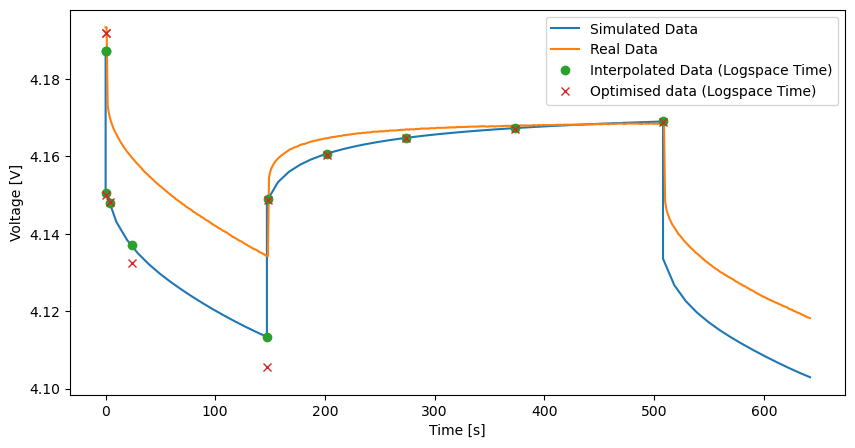

In [10]:
# Visualization results
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, label='Simulated Data')
plt.plot(time_ex, voltage_ex, label='Real Data')
plt.plot(x, voltage_interp, 'o', label='Interpolated Data (Logspace Time)')
plt.plot(time_opt, voltage_opt, 'x', label='Optimised data (Logspace Time)')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

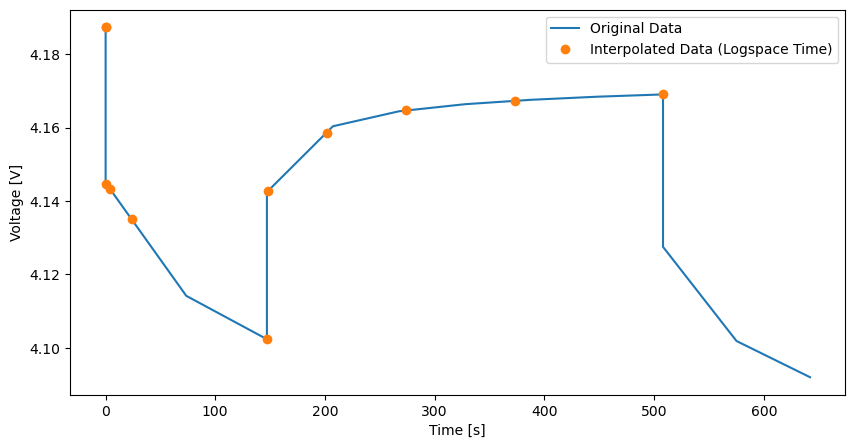

In [3]:
# Visualization results
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, label='Original Data')
plt.plot(x, voltage_interp, 'o', label='Interpolated Data (Logspace Time)')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

In [44]:
# Creating DFN Models
model = pybamm.lithium_ion.DFN()

# Create an experiment
experiment = pybamm.Experiment(
    ["Rest for 0.1 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ], period = "0.1 second"
)

# Setting parameters
param = pybamm.ParameterValues("OKane2022")
# param = model.default_parameter_values
param["Initial concentration in negative electrode [mol.m-3]"] = 0.9*param["Maximum concentration in negative electrode [mol.m-3]"]
# param["Initial concentration in positive electrode [mol.m-3]"] = 0.5*param["Maximum concentration in positive electrode [mol.m-3]"]

# Creating Simulation Objects
solver = pybamm.CasadiSolver(
        mode="safe",
        atol=1e-8,
        rtol=1e-8,
        dt_max=1e-2
    )
simulation = pybamm.Simulation(model, parameter_values=param, solver=solver, experiment=experiment)

# running simulation
solution = simulation.solve(calc_esoh=False)

# Getting results
time = solution["Time [s]"].entries
voltage = solution["Terminal voltage [V]"].entries


# Generate a new point in time using np.logspace
start = 0.1
end = 147
num_points = 5
base = 2

# Generate logspace time points and make sure they are within the simulated time range
x = np.array([0])  # Initialize the time array
x = np.append(
    x, np.logspace(start, end,base = base, num=num_points, endpoint=True)
)
x = np.append(
    x, np.logspace(148, 508, base = base,num=num_points, endpoint=True)
)
# Ensure that the new point in time does not exceed the maximum time of the simulation
max_time = time[-1]
x = x[x <= max_time]

# Calculate the new voltage value using the interpolation function
interp_func = interp1d(time, voltage, kind='linear', fill_value="extrapolate")
voltage_interp = interp_func(x)

df_1 = pd.DataFrame({'Time [s]': x, 'Voltage [V]': voltage_interp})

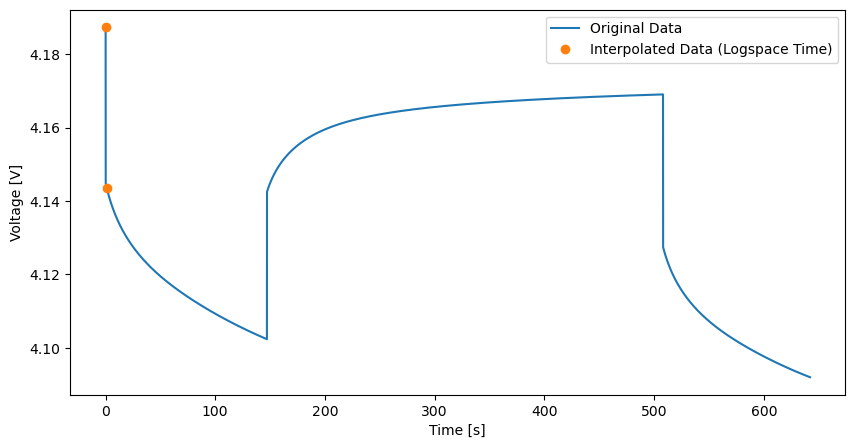

In [45]:
# Visualization results
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, label='Original Data')
plt.plot(x, voltage_interp, 'o', label='Interpolated Data (Logspace Time)')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (644,) and (1544,)

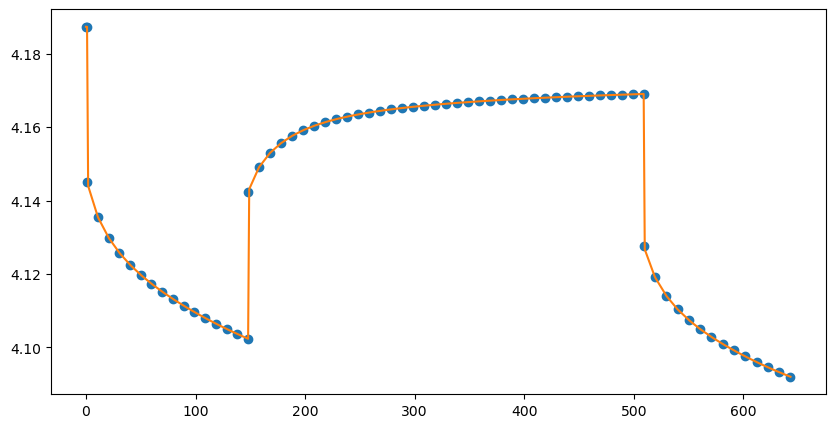

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(time, voltage, 'o', label='Simulated Data')
plt.plot(time_new, voltage_new, '-', label='Interpolated Data')
plt.plot(time_new, voltage_ex, '-', label='Real Data')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.title('Interpolated Voltage Over Time')
plt.legend()
plt.show()

In [ ]:
["Rest for 1 s",
        "Discharge at 0.96 A for 147 s",
        "Rest for 361 s",
        "Discharge at 0.96 A for 134 s"
    ]

In [29]:
param

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x00000266ADF17BA0>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008_arrhenius at 0x00000266AFD5EAC0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008_arrhenius at 0x00000266AFD5F560>,
 'Electron charge [C]': 1.602176634e-19,
 'Exchange-current density for plating [A.m-2]': <function 

In [ ]:
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial concentration in positive electrode [mol.m-3]': 17038.0,
 'Maximum concentration in negative electrode [mol.m-3]': 33133.0,
 'Maximum concentration in positive electrode [mol.m-3]': 63104.0,


In [25]:
start = 0.1

end = 361

num_points = 5

 

 

 

x = 0

x = np.append(x,np.logspace(np.log10(start), np.log10(end), num=num_points, endpoint = True))

x = np.append(x,np.logspace(np.log10(361), np.log10(500), num=num_points, endpoint = True))

y = np.linspace(0,361,num=len(x))



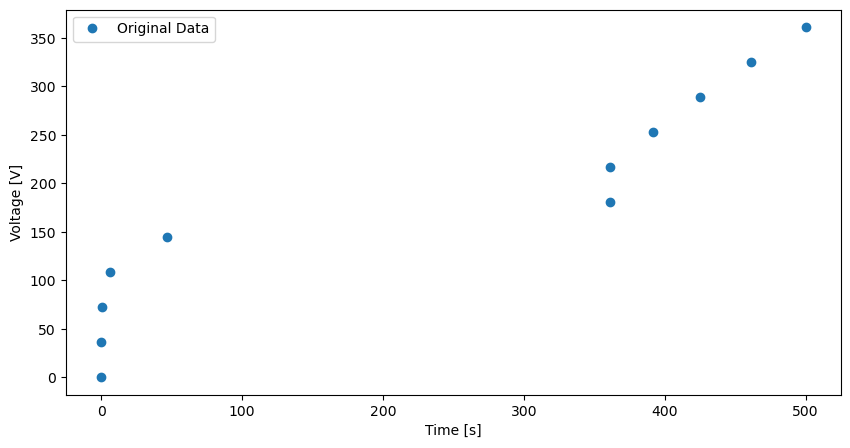

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(x, y,'o', label='Original Data')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend()
plt.show()

In [ ]:
"